# Load Model

In [215]:
import os
from tensorflow.keras.models import load_model
import numpy as np

save_dir = os.path.join("models", "save_experiments")
loaded_model = load_model(os.path.join(save_dir, "saved_model.h5"))

loaded_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 frame_input (InputLayer)    [(None, 45, 1024)]           0         []                            
                                                                                                  
 conv1d_3 (Conv1D)           (None, 45, 10)               51210     ['frame_input[0][0]']         
                                                                                                  
 batch_normalization_3 (Bat  (None, 45, 10)               40        ['conv1d_3[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 leaky_re_lu_3 (LeakyReLU)   (None, 45, 10)               0         ['batch_normalization_3[

# Extract Feature from Video

In [216]:
import cv2
from feature_extractor import feature_extractor
# Reference: https://github.com/google/youtube-8m/tree/master/feature_extractor
# Note that the original module only works for TF 1.x but not 2.0,
# we need to modify the script specifically for tf.GraphDef, tf.Graph, and tf.Session to be
# tf.compat.v1.GraphDef tf.compat.v1.Graph and tf.compat.v1.Session, respectively.

CAP_PROP_POS_MSEC = 0

def frame_iterator(filename, every_ms=1000, max_num_frames=300):
    video_capture = cv2.VideoCapture()
    if not video_capture.open(filename):
        print >> sys.stderr, "Error: Cannot open video file " + filename
        return
    last_ts = -99999  # The timestamp of last retrieved frame.
    num_retrieved = 0
    while num_retrieved < max_num_frames:
        # Skip frames
        while video_capture.get(CAP_PROP_POS_MSEC) < every_ms + last_ts:
            if not video_capture.read()[0]:
                return
        last_ts = video_capture.get(CAP_PROP_POS_MSEC)
        has_frames, frame = video_capture.read()
        if not has_frames:
            break
        yield frame
        num_retrieved += 1

# Pre-trained ImageNet Inception model and PCA matrices will be downloaded if not found.
extractor = feature_extractor.YouTube8MFeatureExtractor("app/models")

def quantize(features, min_quantized_value=-2.0, max_quantized_value=2.0):
  """Quantizes float32 ⁠ features ⁠ into string."""
  assert features.dtype == 'float32'
  assert len(features.shape) == 1  # 1-D array
  features = np.clip(features, min_quantized_value, max_quantized_value)
  quantize_range = max_quantized_value - min_quantized_value
  features = (features - min_quantized_value) * (255.0 / quantize_range)
  features = [int(round(f)) for f in features]

  return features

In [223]:
video_file = "./Sloth.mp4"  # A test sample.

rgb_features = []
sum_rgb_features = None

fiter = frame_iterator(video_file, every_ms=1000.0)

In [224]:
max_frames = 45  # Number of frames to extract

for _ in range(max_frames):
    frame = next(fiter, None)
    if frame is None:
        break
    features = extractor.extract_rgb_frame_features(frame[:, :, ::-1])
    features = quantize(features)
    rgb_features.append(features)

In [225]:
len(rgb_features) #(45,1024)
rgb_features

[[6,
  215,
  88,
  163,
  139,
  160,
  162,
  131,
  150,
  184,
  118,
  161,
  139,
  144,
  100,
  134,
  128,
  143,
  145,
  160,
  117,
  132,
  123,
  108,
  119,
  146,
  162,
  142,
  85,
  116,
  110,
  113,
  91,
  138,
  127,
  110,
  149,
  108,
  126,
  134,
  138,
  179,
  133,
  85,
  155,
  129,
  91,
  109,
  124,
  97,
  142,
  107,
  137,
  144,
  119,
  122,
  130,
  27,
  98,
  110,
  93,
  91,
  132,
  105,
  187,
  164,
  95,
  100,
  107,
  180,
  170,
  172,
  106,
  150,
  69,
  135,
  126,
  86,
  92,
  183,
  164,
  205,
  94,
  141,
  213,
  194,
  44,
  254,
  121,
  153,
  134,
  219,
  143,
  69,
  121,
  79,
  170,
  67,
  109,
  128,
  74,
  125,
  157,
  118,
  77,
  178,
  119,
  177,
  141,
  11,
  140,
  113,
  106,
  125,
  145,
  159,
  69,
  122,
  102,
  109,
  98,
  94,
  191,
  115,
  182,
  108,
  165,
  101,
  131,
  146,
  182,
  134,
  106,
  148,
  160,
  219,
  102,
  98,
  124,
  74,
  110,
  171,
  160,
  154,
  111,
  89,
  150,
 

In [226]:
# Convert the list to a numpy array
rgb_features_array = np.array(rgb_features)

# Reshape the array to add a new axis at the beginning
rgb_features_array = np.expand_dims(rgb_features_array, axis=0)

In [227]:
# Reshape the features into sequences of 45 frames each
predictions = loaded_model.predict(rgb_features_array)
print(predictions)

1/1 [==============================] - 0s 37ms/step
[[8.2638916e-03 4.8854363e-06 9.8202918e-07 1.8010319e-06 9.0641947e-08
  3.4731338e-09 2.4365634e-05 8.1855578e-06 9.9530900e-01]]


In [228]:
predicted_labels = np.argmax(predictions, axis=1)

print(predicted_labels)

[8]


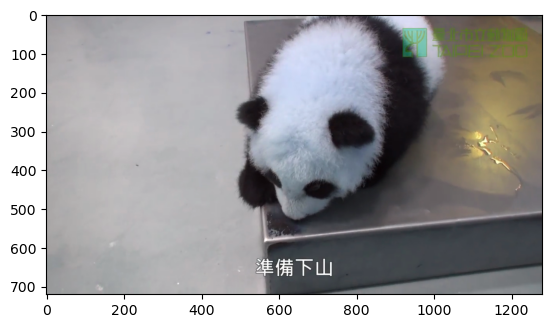

In [214]:
%matplotlib inline
import matplotlib.pyplot as plt

# Take just one frame.
next(fiter)
next(fiter)
next(fiter)
next(fiter)

rgb = next(fiter)

features = extractor.extract_rgb_frame_features(rgb[:, :, ::-1])

# Plot the extracted frame.
f = plt.imshow(rgb)

In [127]:
# The embeddings generated by the pre-trained Inception model on the above frame.
print(features.shape)
print(features)

(1024,)
[ 0.32068577 -0.00784719  1.0262779  ... -2.2360086   0.52385086
 -1.7608215 ]


In [40]:
import cv2
import numpy as np
from feature_extractor import feature_extractor  # Assuming feature_extractor is your feature extraction module

def extract_video_features(video_file, num_frames=45):
    # Initialize the feature extractor
    extractor = feature_extractor.YouTube8MFeatureExtractor("app/models")
    
    # Initialize a list to store the features
    video_features = []
    
    # Open the video file
    cap = cv2.VideoCapture(video_file)
    
    # Calculate frame skip interval to evenly sample frames
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_skip = max(total_frames // num_frames, 1)
    
    # Iterate through the frames of the video
    for i in range(num_frames):
        # Set frame position to skip frames
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * frame_skip)
        
        # Read the next frame
        ret, frame = cap.read()
        
        # Check if the frame was successfully read
        if not ret:
            break  # Break the loop if no more frames are available
        
        # Extract features from the frame
        features = extractor.extract_rgb_frame_features(frame[:, :, ::-1])  # Convert BGR to RGB
        
        # Append the features to the list
        video_features.append(features)
    
    # Close the video file
    cap.release()
    
    # Convert the list of features to a numpy array
    video_features = np.array(video_features)
    
    return video_features

# Example usage:
video_file = "./Music2.mp4"
video_features = extract_video_features(video_file, num_frames=45)
print(video_features.shape)  # Check the shape of the extracted features

(45, 1024)


In [88]:
len(video_features[1])

1024

In [42]:
num_frames = video_features.shape[0]
num_sequences = num_frames // 45

import numpy as np

# Reshape the features into sequences of 45 frames each
video_features_reshaped = video_features[:num_sequences * 45].reshape(-1, 45, 1024)

print(video_features_reshaped.shape)  # Check the shape of the reshaped features

predictions = loaded_model.predict(video_features_reshaped)
print(predictions)

(1, 45, 1024)
1/1 [==============================] - 0s 31ms/step
[[9.9996841e-01 1.3548777e-22 9.4511658e-14 8.6673177e-26 2.2238463e-26
  6.5716002e-26 2.6057550e-21 2.9928954e-22 2.1901466e-02]]


In [43]:
predicted_labels = np.argmax(predictions, axis=1)

print(predicted_labels)

[0]
